> Name: 張宸愷
> ID: 0710018

In [11]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


df = pd.read_csv("data/student-mat.csv", sep=";")  # read csv. I used the mathematics dataset

cats = df.select_dtypes(include=[object])  # select categorical features
num = df.select_dtypes(include=[int])  # select numerical features
cats = pd.get_dummies(cats)  # onehot encode

# combine numerical and categorical data
data_orig = pd.concat([cats, num], axis=1)

def get_data(data_orig:pd.DataFrame, bin_5_classf:int):
    data_orig = data_orig.copy()
    if bin_5_classf == 0:

        classes = ["pass", "fail"]
        data_orig['G3'] = data_orig['G3'].apply(
            lambda x: 0 if x > 10 else 1)

    elif bin_5_classf == 1:
        classes = ["I", "II", "III", "IV", "V"]

        def conv(x):
            if x >= 16:
                return 0
            if x >= 14:
                return 1
            if x >= 12:
                return 2
            if x >= 10:
                return 3

            return 4

        data_orig['G3'] = data_orig['G3'].apply(conv)

    return data_orig.to_numpy(), classes

data_binary, c_bin = get_data(data_orig, 0)
data_5level, c_5 = get_data(data_orig, 1)

np.random.shuffle(data_binary)
np.random.shuffle(data_5level)


def r2np(r: dict, length_clss:int):
        nn = np.ndarray((length_clss, 3))
        for c in range(length_clss):
            a = str(c)
            nn[c] = [r[a]["precision"], r[a]["recall"], r["accuracy"]]

        # return [precision, recall, accuracy]
        return nn


In [12]:
# Decision tree


def decision_tree_r(data, classes, do_PCA, title: str):
    clss = len(classes)
    PCA_dim = 3
    def decision_t(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        T_cls = tree.DecisionTreeClassifier()
        T_cls.fit(X_train, y_train)
        y_pred = T_cls.predict(X_test)
        r = classification_report(y_test, y_pred, output_dict=True)
        c = confusion_matrix(y_test, y_pred)

        return r, c

    kfold = KFold(n_splits=3, shuffle=True)
    rs = np.zeros((len(classes), 3))
    cs = np.zeros((clss, clss))
    for train_index, test_index in kfold.split(data):
        train, test = data[train_index], data[test_index]
        X_train, y_train, X_test, y_test = train[:,
                                                 0:-1], train[:, -1], test[:, 0:-1], test[:, -1]
        pca = PCA(n_components=PCA_dim)
        if do_PCA:
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        r, confm = decision_t(X_train, y_train, X_test, y_test)
        rs += r2np(r, clss)
        cs += confm
    # get average
    rs = rs/3
    cs = cs/3

    # show data
    print("### "+title)
    rs = pd.DataFrame(rs, index=classes, columns=[
        'precision', 'recall', 'accuracy'])
    print("report classification\n")
    print(rs.to_markdown())
    cs = pd.DataFrame(cs, index=["true " + x for x in classes],
                      columns=["pred " + x for x in classes])
    print("")
    print("confusion matrix\n")
    print(cs.to_markdown())


b = [0, 0, 1, 1]
p = [False, True, False, True]
title = ["binary, no PCA", "binary, PCA", "5-level, no PCA", "5-level, PCA"]

for i in range(4):
    if b[i] == 0:
        decision_tree_r(data_binary, c_bin, p[i], title[i])
    elif b[i] == 1:
        decision_tree_r(data_5level, c_5, p[i], title[i])


### binary, no PCA
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.887954 | 0.929121 |    0.89872 |
| fail |    0.918931 | 0.868075 |    0.89872 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    64.6667  |      5      |
| true fail |     8.33333 |     53.6667 |
### binary, PCA
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.928743 | 0.886355 |   0.903809 |
| fail |    0.876198 | 0.924512 |   0.903809 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    61.6667  |      8      |
| true fail |     4.66667 |     57.3333 |
### 5-level, no PCA
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.716006 | 0.656396 |  

In [13]:
# Random forest

from sklearn.ensemble import RandomForestClassifier


def random_f_r(data, classes, do_PCA, num_trees: int, title: str):
    clss = len(classes)
    PCA_dim = 3
    rs = np.zeros((clss, 3))
    cs = np.zeros((clss, clss))

    def random_f(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        R_cls = RandomForestClassifier(num_trees)
        R_cls.fit(X_train, y_train)
        y_pred = R_cls.predict(X_test)
        r = classification_report(y_test, y_pred, output_dict=True)
        c = confusion_matrix(y_test, y_pred)
        return r, c

    kfold = KFold(n_splits=3, shuffle=True)

    rs = np.zeros((len(classes), 3))
    cs = np.zeros((clss, clss))
    for train_index, test_index in kfold.split(data):
        train, test = data[train_index], data[test_index]
        X_train, y_train, X_test, y_test = train[:,
                                                 0:-1], train[:, -1], test[:, 0:-1], test[:, -1]
        pca = PCA(n_components=PCA_dim)
        if do_PCA:
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        r, confm = random_f(X_train, y_train, X_test, y_test)
        rs += r2np(r, clss)
        cs += confm
    rs = rs / 3
    cs = cs / 3

    # show data
    print("### "+title)

    rs = pd.DataFrame(rs, index=classes, columns=[
        'precision', 'recall', 'accuracy'])
    print("report classification\n")
    print(rs.to_markdown())
    cs = pd.DataFrame(cs, index=["true " + x for x in classes],
                      columns=["pred " + x for x in classes])
    print("")
    print("confusion matrix\n")
    print(cs.to_markdown())


b = [0, 0, 1, 1, 0, 0]
p = [False, True, False, True, False, False]
trees = [10, 10, 10, 10, 50, 200]
title = ["binary, no PCA ,trees = 10",
         "binary, PCA, trees = 10",
         "5-level, no PCA, trees = 10",
         "5-level, PCA, trees = 10",
         "binary, no PCA, trees = 50",
         "binary, no PCA, trees = 200"]


for i in range(6):
    if b[i] == 0:
        random_f_r(data_binary, c_bin, p[i], trees[i], title[i])
    elif b[i] == 1:
        random_f_r(data_5level, c_5, p[i], trees[i], title[i])


### binary, no PCA ,trees = 10
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.913574 | 0.909731 |   0.906354 |
| fail |    0.897631 | 0.904195 |   0.906354 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |     63.3333 |     6.33333 |
| true fail |      6      |    56       |
### binary, PCA, trees = 10
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.924293 | 0.920189 |   0.919018 |
| fail |    0.916205 | 0.911019 |   0.919018 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    64.3333  |     5.33333 |
| true fail |     5.33333 |    56.6667  |
### 5-level, no PCA, trees = 10
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:

In [14]:
# K nearest neighbors

from sklearn.neighbors import KNeighborsClassifier


def knn_r(data, classes, do_PCA, K_n, title: str):
    clss = len(classes)
    PCA_dim = 3

    def knn(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        knn = KNeighborsClassifier(n_neighbors=K_n)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        r = classification_report(y_test, y_pred, output_dict=True)
        c = confusion_matrix(y_test, y_pred)

        return r, c

    kfold = KFold(n_splits=3, shuffle=True)
    rs = np.zeros((len(classes), 3))
    cs = np.zeros((clss, clss))
    for train_index, test_index in kfold.split(data):
        train, test = data[train_index], data[test_index]
        X_train, y_train, X_test, y_test = train[:,
                                                 0:-1], train[:, -1], test[:, 0:-1], test[:, -1]
        pca = PCA(n_components=PCA_dim)
        if do_PCA:
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
        r, confm = knn(X_train, y_train, X_test, y_test)
        rs += r2np(r, clss)
        cs += confm
    rs = rs / 3
    cs = cs / 3

    # show data
    print("### "+title)

    rs = pd.DataFrame(rs, index=classes, columns=[
        'precision', 'recall', 'accuracy'])
    print("report classification\n")
    print(rs.to_markdown())
    cs = pd.DataFrame(cs, index=["true " + x for x in classes],
                      columns=["pred " + x for x in classes])
    print("")
    print("confusion matrix\n")
    print(cs.to_markdown())


b = [0, 0, 1, 1, 0, 0]
p = [False, True, False, True, False, False]
k = [5, 5, 5, 5, 3, 8]
title = ["binary, no PCA, k = 5",
         "binary, PCA, k = 5",
         "5-level, no PCA, k = 5",
         "5-level, PCA, k = 5",
         "binary, no PCA, k = 3",
         "binary, no PCA, k = 8"]

for i in range(6):
    if b[i] == 0:
        random_f_r(data_binary, c_bin, p[i], k[i], title[i])
    elif b[i] == 1:
        random_f_r(data_5level, c_5, p[i], k[i], title[i])


### binary, no PCA, k = 5
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.903514 | 0.909834 |   0.901226 |
| fail |    0.896398 | 0.895801 |   0.901226 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    63.3333  |     6.33333 |
| true fail |     6.66667 |    55.3333  |
### binary, PCA, k = 5
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.91129  | 0.897165 |   0.896195 |
| fail |    0.885755 | 0.901386 |   0.896195 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    62.3333  |     7.33333 |
| true fail |     6.33333 |    55.6667  |
### 5-level, no PCA, k = 5
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.

# Results & Comparison
## 1. Decision Tree

### binary, no PCA
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.885036 | 0.899951 |   0.883665 |
| fail |    0.882092 | 0.863378 |   0.883665 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    62.6667  |      7      |
| true fail |     8.33333 |     53.6667 |
### binary, PCA
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.919827 | 0.884363 |   0.898778 |
| fail |    0.879708 | 0.91427  |   0.898778 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    61.6667  |      8      |
| true fail |     5.33333 |     56.6667 |
### 5-level, no PCA
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.655556 | 0.794805 |   0.635361 |
| II  |    0.585633 | 0.57037  |   0.635361 |
| III |    0.521183 | 0.390783 |   0.635361 |
| IV  |    0.545543 | 0.591792 |   0.635361 |
| V   |    0.785185 | 0.778704 |   0.635361 |

confusion matrix

|          |    pred I |   pred II |   pred III |   pred IV |    pred V |
|:---------|----------:|----------:|-----------:|----------:|----------:|
| true I   | 10.6667   |  2.33333  |   0.333333 |  0        |  0        |
| true II  |  5.33333  | 11.3333   |   2.66667  |  0.666667 |  0        |
| true III |  0.333333 |  5.33333  |   8        |  6.66667  |  0.333333 |
| true IV  |  0        |  0.666667 |   4.66667  | 20        |  9        |
| true V   |  0        |  0        |   0        |  9.66667  | 33.6667   |
### 5-level, PCA
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.601901 | 0.67381  |   0.584683 |
| II  |    0.505011 | 0.486756 |   0.584683 |
| III |    0.383214 | 0.345871 |   0.584683 |
| IV  |    0.492899 | 0.515729 |   0.584683 |
| V   |    0.771874 | 0.776956 |   0.584683 |

confusion matrix

|          |   pred I |   pred II |   pred III |   pred IV |   pred V |
|:---------|---------:|----------:|-----------:|----------:|---------:|
| true I   | 9        |   4.33333 |   0        |   0       |  0       |
| true II  | 6        |   9.33333 |   3.33333  |   1.33333 |  0       |
| true III | 0.333333 |   3.66667 |   7.33333  |   7.66667 |  1.66667 |
| true IV  | 0        |   1       |   7.33333  |  17.6667  |  8.33333 |
| true V   | 0        |   0       |   0.333333 |   9.33333 | 33.6667  |




## 2. Random Forest

### binary, no PCA ,trees = 10
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.895021 | 0.933456 |   0.906392 |
| fail |    0.92116  | 0.87606  |   0.906392 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    65       |     4.66667 |
| true fail |     7.66667 |    54.3333  |
### binary, PCA, trees = 10
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.909619 | 0.919095 |   0.908898 |
| fail |    0.907461 | 0.900311 |   0.908898 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    64       |     5.66667 |
| true fail |     6.33333 |    55.6667  |
### 5-level, no PCA, trees = 10
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.588889 | 0.444932 |   0.546842 |
| II  |    0.466667 | 0.561508 |   0.546842 |
| III |    0.356421 | 0.276136 |   0.546842 |
| IV  |    0.426401 | 0.452808 |   0.546842 |
| V   |    0.726238 | 0.787006 |   0.546842 |

confusion matrix

|          |   pred I |   pred II |   pred III |   pred IV |    pred V |
|:---------|---------:|----------:|-----------:|----------:|----------:|
| true I   |  6       |   6.33333 |   0.333333 |  0.666667 |  0        |
| true II  |  4.33333 |  11       |   2.66667  |  1.33333  |  0.666667 |
| true III |  0       |   4.66667 |   5.66667  |  9.33333  |  1        |
| true IV  |  0       |   1.66667 |   5.66667  | 15.3333   | 11.6667   |
| true V   |  0       |   0       |   0        |  9.33333  | 34        |
### 5-level, PCA, trees = 10
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.712673 | 0.743452 |   0.635419 |
| II  |    0.629474 | 0.605235 |   0.635419 |
| III |    0.516154 | 0.477785 |   0.635419 |
| IV  |    0.522042 | 0.60945  |   0.635419 |
| V   |    0.803104 | 0.725092 |   0.635419 |

confusion matrix

|          |   pred I |   pred II |   pred III |   pred IV |   pred V |
|:---------|---------:|----------:|-----------:|----------:|---------:|
| true I   |  9.66667 |    3      |   0.666667 |   0       |  0       |
| true II  |  4.66667 |   11.6667 |   2.33333  |   1.33333 |  0       |
| true III |  0       |    4      |  10        |   6.66667 |  0       |
| true IV  |  0       |    0      |   5.66667  |  21       |  7.66667 |
| true V   |  0       |    0      |   0.666667 |  11.3333  | 31.3333  |
### binary, no PCA, trees = 50
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.949029 | 0.936262 |   0.941707 |
| fail |    0.931951 | 0.949636 |   0.941707 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    65.3333  |     4.33333 |
| true fail |     3.33333 |    58.6667  |
### binary, no PCA, trees = 200
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.938511 | 0.933046 |   0.931645 |
| fail |    0.925271 | 0.929896 |   0.931645 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    65       |     4.66667 |
| true fail |     4.33333 |    57.6667  |


## 3. KNN

### binary, no PCA, k = 5
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.918114 | 0.909962 |    0.90886 |
| fail |    0.899349 | 0.909091 |    0.90886 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    63.3333  |     6.33333 |
| true fail |     5.66667 |    56.3333  |
### binary, PCA, k = 5
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.939967 | 0.919339 |   0.926613 |
| fail |    0.910145 | 0.936144 |   0.926613 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |          64 |     5.66667 |
| true fail |           4 |    58       |
### 5-level, no PCA, k = 5
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.590567 | 0.623016 |   0.584875 |
| II  |    0.498519 | 0.600189 |   0.584875 |
| III |    0.439683 | 0.344928 |   0.584875 |
| IV  |    0.537302 | 0.548387 |   0.584875 |
| V   |    0.75323  | 0.718157 |   0.584875 |

confusion matrix

|          |   pred I |   pred II |   pred III |   pred IV |   pred V |
|:---------|---------:|----------:|-----------:|----------:|---------:|
| true I   | 8.33333  |  5        |    0       |  0        |  0       |
| true II  | 5.33333  | 11.6667   |    2.33333 |  0.666667 |  0       |
| true III | 0.666667 |  5.33333  |    7.33333 |  6        |  1.33333 |
| true IV  | 0.333333 |  1.33333  |    4.33333 | 18.6667   |  9.66667 |
| true V   | 0        |  0.333333 |    2.33333 |  9.66667  | 31       |
### 5-level, PCA, k = 5
report classification

|     |   precision |   recall |   accuracy |
|:----|------------:|---------:|-----------:|
| I   |    0.646886 | 0.601207 |   0.605135 |
| II  |    0.532281 | 0.553175 |   0.605135 |
| III |    0.405407 | 0.477904 |   0.605135 |
| IV  |    0.538961 | 0.459855 |   0.605135 |
| V   |    0.788574 | 0.815622 |   0.605135 |

confusion matrix

|          |   pred I |   pred II |   pred III |   pred IV |    pred V |
|:---------|---------:|----------:|-----------:|----------:|----------:|
| true I   |  8       |   4.66667 |   0.666667 |  0        |  0        |
| true II  |  4.33333 |  11       |   4        |  0.666667 |  0        |
| true III |  0       |   4.33333 |   9.66667  |  6.33333  |  0.333333 |
| true IV  |  0       |   1.33333 |   8        | 16        |  9        |
| true V   |  0       |   0       |   1.66667  |  6.66667  | 35        |
### binary, no PCA, k = 3
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.871552 | 0.866904 |   0.860803 |
| fail |    0.850497 | 0.857155 |   0.860803 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |     60.3333 |     9.33333 |
| true fail |      9      |    53       |
### binary, no PCA, k = 8
report classification

|      |   precision |   recall |   accuracy |
|:-----|------------:|---------:|-----------:|
| pass |    0.895552 | 0.933456 |   0.906257 |
| fail |    0.922928 | 0.87619  |   0.906257 |

confusion matrix

|           |   pred pass |   pred fail |
|:----------|------------:|------------:|
| true pass |    65       |     4.66667 |
| true fail |     7.66667 |    54.3333  |


# Questions

## Q1 Decision Tree
> Show the prediction and reasoning of one arbitrary sample in the testing set. - 10%

### A:
The sklearn decision tree library is a CART algorithm.


Rules used to predict sample 0:

decision node 0 : (X_test[0, 57] = 7) <= 10.5)
decision node 1 : (X_test[0, 56] = 8) <= 11.5)
decision node 2 : (X_test[0, 52] = 1) <= 4.5)
decision node 3 : (X_test[0, 43] = 16) > 15.5)
decision node 7 : (X_test[0, 35] = 0) <= 0.5)
predicted: fail
true: fail


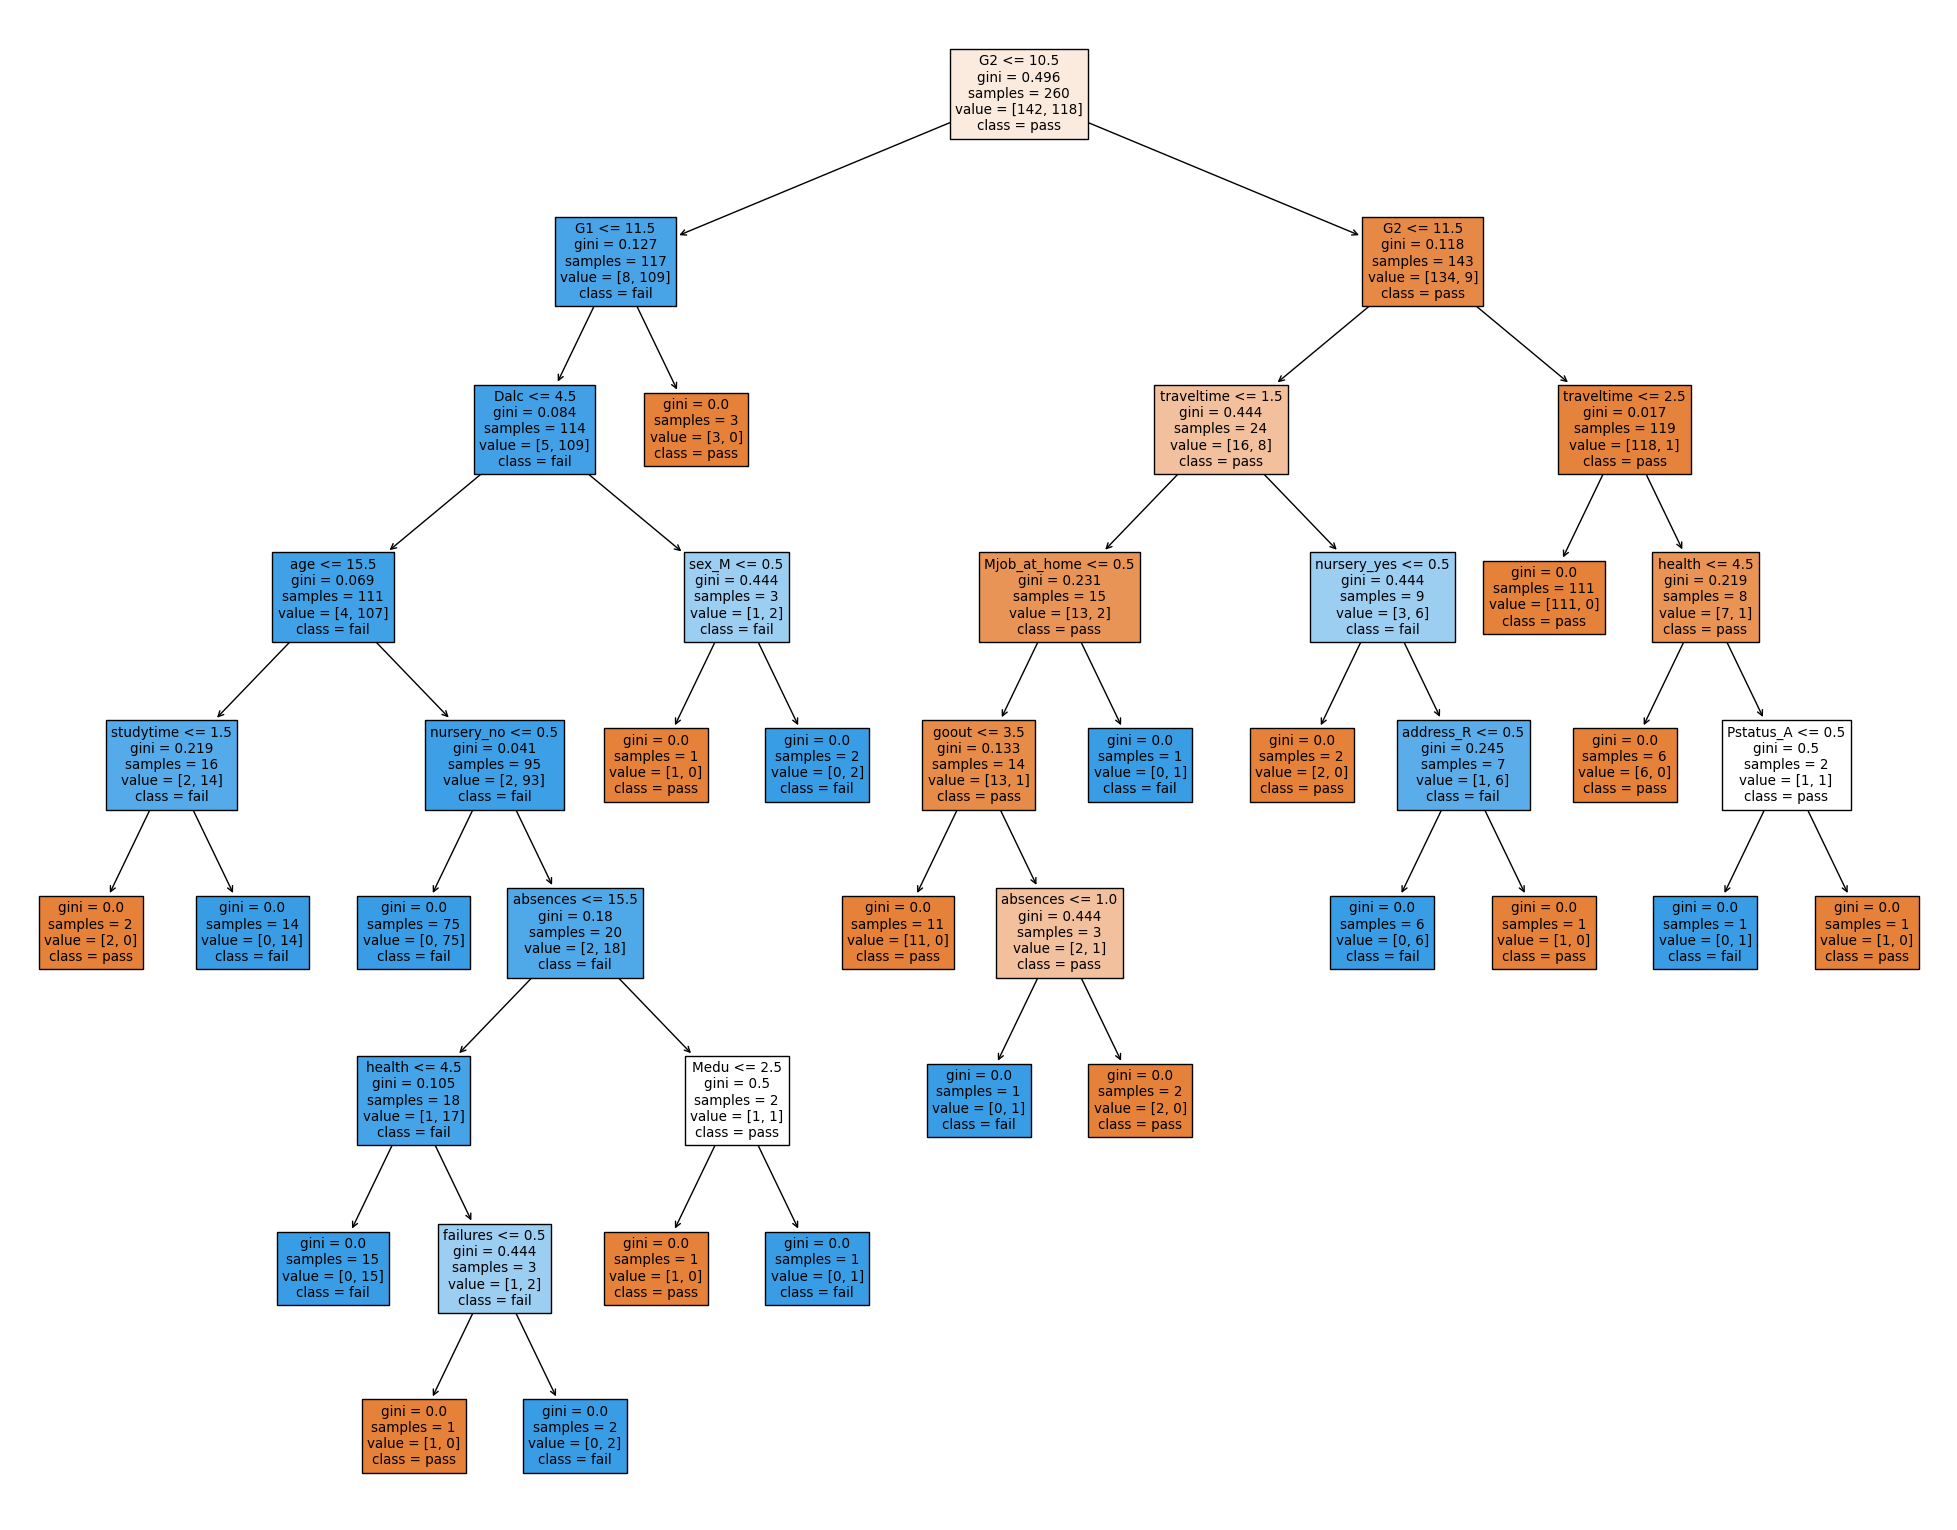

In [15]:

regenerate = True

if regenerate:
    T_cls = tree.DecisionTreeClassifier()
    training = data_binary[0:260, :]
    validate = data_binary[300, :]
    test = np.reshape(validate[0:-1], (1, training.shape[1]-1))
    T_cls.fit(training[:, 0:-1], training[:, -1])
    pred = T_cls.predict(test)

    leaf_id = T_cls.apply(test)
    feature = T_cls.tree_.feature
    threshold = T_cls.tree_.threshold
    path = T_cls.decision_path(test)
    print()

    sample_id = 0
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = path.indices[
        path.indptr[sample_id] : path.indptr[sample_id + 1]
    ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=test[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )



    print("predicted: {}\ntrue: {}".format(
        c_bin[pred[0]], c_bin[validate[-1]]))
    fig = plt.figure(figsize=(25, 20), dpi=100)
    _ = tree.plot_tree(T_cls, feature_names=data_orig.columns,
                       class_names=c_bin,
                       filled=True)


## Q2 Random Forest
> Describe the difference between boosting and bagging. - 5%

### A:
Both boosting and bagging randomly samples training data to get new training data sets, but boosting will focus more on the previously failed data when sampling again. Both ensemble methods generate the predictions by voting and selecting the highest vote, but in boosting, each weak learner will have a weight associate with them which is determined by their performance when the learners were trained on the training set. The higher the training performance, the more weight it carries. Both methods increase the stability and reduces the variance. Boosting reduces bias but may lead to over-fitting.




## Q3 KNN
> Show the prediction and reasoning of one arbitrary sample in the testing set. - 10%

### A:


> Bonus: pick 2 features, draw and describe the KNN decision boundaries. - 10%
You can pick 2 features to re-train the model, or just fix every other feature value.
### A:


## Q4 PCA
> In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels. - 10%

### A:


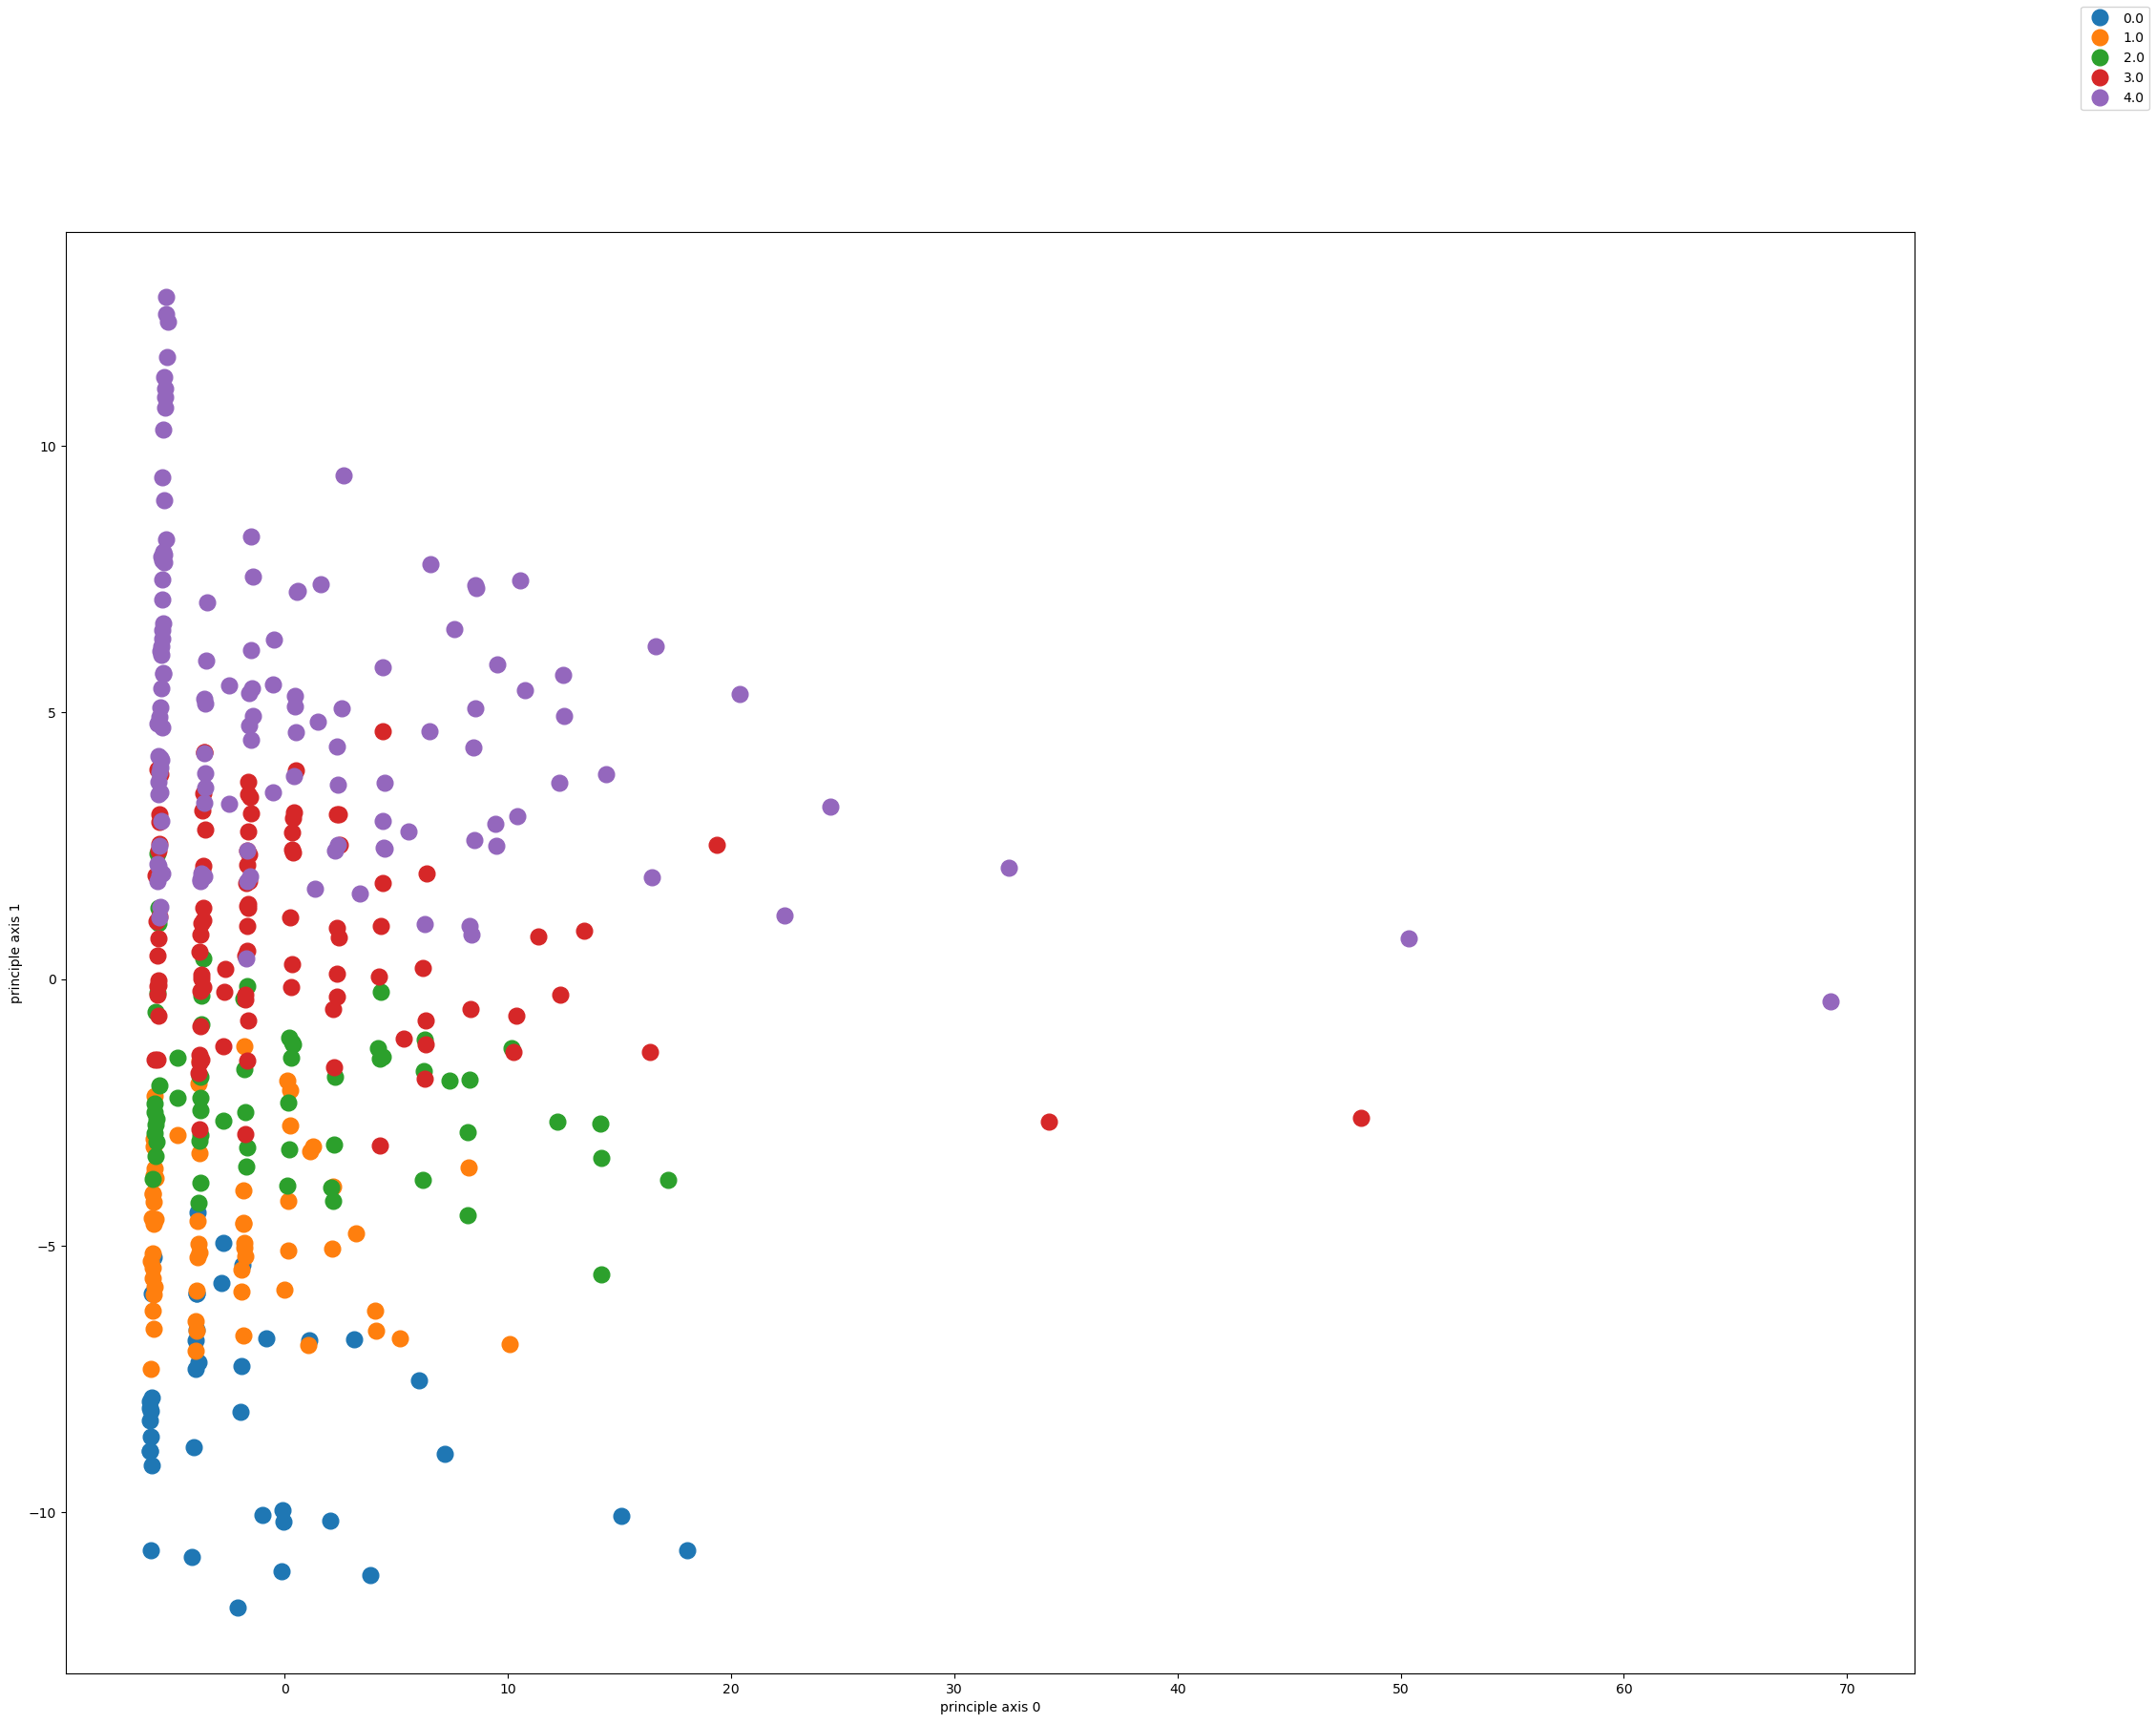

In [60]:
pc = PCA(n_components=2)


features = data_5level[:,0:-1]
label = np.expand_dims(data_5level[:, -1], axis=1)
pc = pc.fit_transform(features)
pc = np.concatenate([pc, label], axis=1)
dataf = pd.DataFrame(pc)
groups = dataf.groupby(2)

fig = plt.figure(figsize=(25, 20), dpi=100)


for name, group in groups:
    cc = np.array(group[2]).astype(np.int8)
    _ = plt.plot(group[0], group[1], marker='o', linestyle='', markersize=12, label=name)
    # s = plt.plot(group[0], group[1], c=cc, label = c_5[int(name)])

_ = fig.legend(loc='upper right')
_ = plt.xlabel("principle axis 0")
_ = plt.ylabel("principle axis 1")